In [1]:
import serial, time
ser = serial.Serial('/dev/ttyACM0', 115200)

In [4]:
def read_all():
    r = ser.read_all() # clear buffer
    ser.write(b'a')
    while ser.in_waiting < 1:
        pass # wait for a response
    time.sleep(0.05)
    r = ser.read_all()
    t = str(r).split('A')[-1].strip()
    r = [[int(s.strip('b\'')) for s in str(l).split(',')[:8]] for l in str(r).split('A')[:-1]]
    return(r, t)

In [6]:
import numpy as np
r, t = read_all()
np.asarray(r)

array([[719, 727, 683, 481, 734, 725, 721, 719],
       [735, 732, 520, 731, 709, 724, 707, 730],
       [724, 724, 728, 680, 730, 724, 740, 724],
       [740, 725, 716, 727, 545, 718, 735, 689],
       [732, 721, 718, 717, 731, 683, 615, 726],
       [591, 691, 708, 743, 721, 727, 717, 722],
       [668, 485, 723, 729, 725, 727, 674, 733],
       [702, 724, 727, 721, 733, 728, 717, 592]])

In [7]:
from IPython.display import clear_output
for i in range(100):
    r, t = read_all()
    print(np.asarray(r))
    time.sleep(0.1)
    clear_output(wait=True)

[[729 726 683 489 724 724 719 728]
 [709 731 498 720 717 712 707 723]
 [728 721 722 679 744 738 712 730]
 [714 739 721 726 538 710 712 690]
 [740 731 725 738 737 682 621 735]
 [589 687 714 730 727 743 718 724]
 [674 473 716 721 740 715 685 721]
 [712 721 722 733 719 734 720 596]]


In [231]:
def read_av():
    read = np.asarray(read_all()[0]).flatten()
    for i in range(10):
        read = read+(np.asarray(read_all()[0]).flatten())
    return read/10

In [232]:
base = read_all()[0]

In [233]:
from matplotlib import pyplot as plt
%matplotlib inline

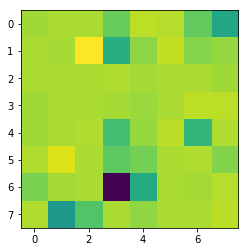

In [234]:
read = read_all()[0]
plt.imshow(np.asarray(base)-np.asarray(read))

In [27]:
base

[[874, 887, 885, 891, 701, 866, 883, 891],
 [890, 885, 885, 892, 866, 834, 788, 882],
 [864, 892, 881, 887, 878, 893, 791, 826],
 [769, 881, 895, 899, 873, 893, 889, 853],
 [872, 855, 885, 895, 873, 904, 881, 891],
 [890, 860, 824, 882, 889, 870, 872, 891],
 [864, 895, 872, 670, 888, 893, 862, 886],
 [874, 895, 895, 820, 842, 891, 892, 888]]

# Image recon

In [235]:
# Import required libraries
from image_util import *
import skimage.filters
from matplotlib import pyplot as plt
import cairocffi as cairo
import math, random
import numpy as np
import pandas as pd
from IPython.display import Image
from scipy.interpolate import interp1d
import astra

%matplotlib inline

def r8_to_sino(readings):
    sino = []
    for e in range(8):
        start = e*8 + (e+2)%8
        end = e*8 + (e+6)%8
        if end-start == 4:
            sino.append(readings[start : end])
        else:
            r = readings[start : (e+1)*8]
            for p in readings[e*8 : end]:
                r.append(p)
            sino.append(r)
    return np.asarray(sino)


In [281]:
nviews = 8
ndetectors = 4
nvdetectors = 8

IMSIZE = 50
R = IMSIZE/2
D = IMSIZE/2

# Transforming from a round fan-beam to a fan-flat projection (See diagram)
beta = np.linspace(math.pi/8, 7*math.pi/8, ndetectors)
alpha = np.asarray([R*math.sin(b-math.pi/2)/(R**2 + D**2)**0.5 for b in beta])
tau = np.asarray([(R+D)*math.tan(a) for a in alpha])

tau_new = np.linspace(-(max(tau)/2), max(tau)/2, nvdetectors)

vol_geom = astra.create_vol_geom(IMSIZE, IMSIZE)
angles = np.linspace(0,2*math.pi,nviews);
d_size = (tau[-1]-tau[0])/nvdetectors
proj_geom= astra.create_proj_geom('fanflat', d_size, nvdetectors, angles, D, R);
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

In [296]:
base = read_av()

In [297]:
np.asarray(base).reshape(8,8)

array([[941. , 939.6, 964.4, 971.9, 958.5, 959.3, 962.8, 963.8],
       [953.6, 924.8, 945.4, 959.8, 964.2, 958.7, 963.7, 962.9],
       [987.8, 959.1, 930.4, 938.4, 959.2, 958. , 981.9, 960.9],
       [991.4, 965.3, 975.7, 912.3, 921.2, 975.5, 975.5, 973.4],
       [957.6, 973.9, 979.8, 966.5, 926.7, 889. , 979.2, 972.3],
       [957.9, 966.4, 957.9, 973.2, 955.9, 901.2, 936.5, 958.9],
       [954.9, 960.9, 977. , 961.7, 956.4, 956.3, 935. , 938.7],
       [938.8, 960.6, 983.6, 955.1, 959. , 959.8, 962.5, 939. ]])

0
17.877346222440426
CPU times: user 582 ms, sys: 310 ms, total: 891 ms
Wall time: 972 ms


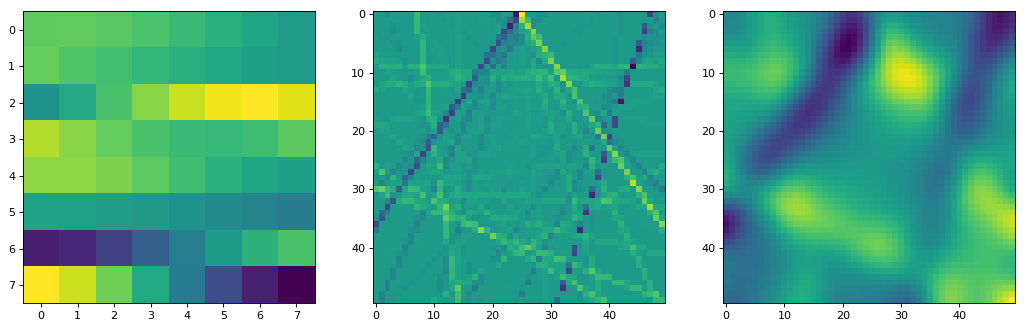

In [309]:
%%time
for i in range(1):
    print(i)
    r2 = read_av()
    readings = (np.asarray(base)-np.asarray(r2))# - base
    readings = r8_to_sino(readings.tolist()) # Get important ones and reorder
    
    readings2 = []
    for r in readings:
        f = interp1d(tau, r, kind='cubic') # Can change to linear
        readings2.append(f(tau_new))
        
    
    sinogram_id = astra.data2d.create('-sino', proj_geom, np.asarray(readings2))
    
    # Plotting sinogram - new (transformed) set of readings
    plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(readings2) #<< Set title

    # Doing the reconstruction, in this case with FBP

    rec_id = astra.data2d.create('-vol', vol_geom)

    cfg = astra.astra_dict('FBP')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = proj_id

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    astra.algorithm.run(alg_id, 1)

    # Get the result
    rec = astra.data2d.get(rec_id)
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(rec)
    norm_rec = rec/(np.amax(np.abs(rec)))
    blurred = skimage.filters.gaussian(norm_rec, 3)
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(blurred)
    
    plt.savefig('r8s'+str(i) + '.png')
    print(max(np.asarray(readings2).flatten()))


In [ ]:
# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)

In [ ]:
np.linspace(math.pi/8, 7*math.pi/8, ndetectors)

In [ ]:
np.linspace(0, math.pi, ndetectors)

In [537]:
r = []
y = []
y2 = []
for i in range(50):
    r.append(np.asarray(read_all()[0]).flatten())
    y.append(0)
    y2.append(0)

In [543]:
for i in range(50):
    r.append(np.asarray(read_all()[0]).flatten())
    y.append(2)
    y2.append(2)

In [548]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(r, y)

regr = RandomForestClassifier(max_depth=5, random_state=0)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

1.0

In [473]:
regr.predict([np.asarray(read_all()[0]).flatten()])

array([2])

In [556]:
df = pd.read_csv('r8_small_rotation.csv')
r = df[[str(i) for i in range(64)]]
y = df['Y']

from sklearn.neural_network import MLPClassifier, MLPRegressor
X_train, X_test, y_train, y_test = train_test_split(r, y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlpc = MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=400)
mlpc.fit(X_train, y_train)
print(mlpc.score(X_test, y_test))

0.9557522123893806


In [557]:
from IPython.display import clear_output
av = 0
while True:
    read = [np.asarray(read_all()[0]).flatten()]
    read = scaler.transform(read)
    print(mlpc.predict(read))
    time.sleep(0.1)
    clear_output(wait=True)

[1]


KeyboardInterrupt: 

In [536]:
ser.read_all()

b''

In [464]:
import pandas as pd
df1 = pd.DataFrame(r)
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,853,854,882,873,874,907,897,875,867,854,...,850,852,856,873,883,863,873,872,872,846
1,860,854,882,872,871,876,881,876,866,854,...,851,854,855,896,889,863,897,871,875,854
2,860,853,882,874,870,874,868,876,867,854,...,851,854,855,874,864,865,874,870,872,854
3,861,854,885,873,870,874,881,877,868,854,...,852,854,856,874,885,863,877,871,874,854
4,859,854,882,873,871,897,881,877,866,854,...,850,854,855,874,888,898,903,872,874,845


In [465]:
df1['Y'] = y
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,Y
0,853,854,882,873,874,907,897,875,867,854,...,852,856,873,883,863,873,872,872,846,0
1,860,854,882,872,871,876,881,876,866,854,...,854,855,896,889,863,897,871,875,854,0
2,860,853,882,874,870,874,868,876,867,854,...,854,855,874,864,865,874,870,872,854,0
3,861,854,885,873,870,874,881,877,868,854,...,854,856,874,885,863,877,871,874,854,0
4,859,854,882,873,871,897,881,877,866,854,...,854,855,874,888,898,903,872,874,845,0


In [466]:
df1.to_csv('r8_small_rotation.csv', index=False)